Make training and test data

hr is gas positions from TNG300-1.

lr is dark matter positions from Arepo with 128 particles.

In [7]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
from os import mkdir, path
from shutil import rmtree
from tqdm import tqdm

In [8]:
def normalize(x, mean, std): return (x - mean) / std

def sigmoid(x): return 1/(1+np.exp(-x))

def softplus(x, eps=10e-6): return np.log(1+np.exp(x))

def inv_softplus(x, eps=10e-6): return np.log(np.exp(x)-1+eps)

def regularize(x, mean, std): return sigmoid(normalize(x, mean, std))*2 - 1

def inv_regularize(x, mean, std):
    x = (x+1)/2
    return (np.log(x/(1-x)))*std + mean

def load_data(path): return np.log1p(np.load(path))

base_dir = '/home/user/sr_cosmology/data/full_cubes/'

Inspect training data

In [9]:
hr_gas = load_data(base_dir+'hr/gas_density_CIC_264px.npy')
lr_trn = load_data(base_dir+'lr/dm_CIC_arepo_264px_128p_seed4443.npy')

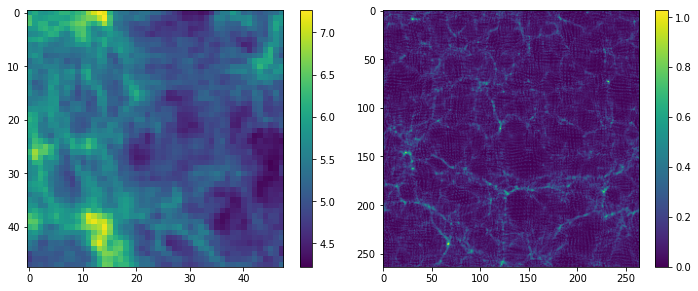

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot1 = ax[0].imshow(np.mean(hr_gas[:48, :48, :48], axis=-1))
plt.colorbar(plot1, ax=ax[0])
plot2 = ax[1].imshow(np.mean(lr_trn[:, :, :24], axis=-1))
plt.colorbar(plot2, ax=ax[1])
plt.tight_layout()

In [12]:
shift_hr = 5.4580938751245895
shift_lr = 0.084621996
scale_hr = 2.518257756763228
scale_lr = 0.7193434834480286

hr_gas_reg = regularize(hr_gas, shift_hr, scale_hr)
lr_trn_reg = regularize(lr_trn, shift_lr, scale_lr)

hr_gas_again = inv_regularize(hr_gas_reg, shift_hr, scale_hr)
lr_trn_again = inv_regularize(lr_trn_reg, shift_lr, scale_lr)

In [13]:
print(shift_hr, shift_lr, scale_hr, scale_lr)

5.4580938751245895 0.084621996 2.518257756763228 0.7193434834480286


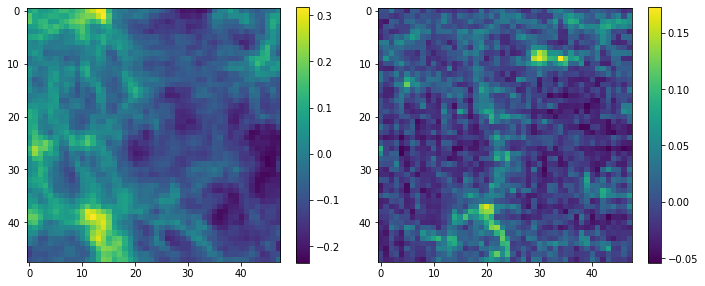

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot1 = ax[0].imshow(np.mean(hr_gas_reg[:48, :48, :48], axis=-1))
plt.colorbar(plot1, ax=ax[0])
plot2 = ax[1].imshow(np.mean(lr_trn_reg[:48, :48, :48], axis=-1))
plt.colorbar(plot2, ax=ax[1])
plt.tight_layout()

Make training data

In [19]:
def generate_sequential_pairs(directory, crop, stride, lr_data=None):
    mkdir(directory)
    mkdir(f'{directory}/lr')

    fnames = []
    i = 0

    for x_start in range(0, 264-stride, stride):
        for y_start in range(0, 264-stride, stride):
            for z_start in range(0, 264-stride, stride):
                x_end = x_start + crop
                y_end = y_start + crop
                z_end = z_start + crop

                fname = f'{i}-x-{x_start}-y-{y_start}-z-{z_start}'
                fnames.append(fname)

                img_lr = lr_trn_reg[x_start:x_end, y_start:y_end, z_start:z_end].astype(np.float32)
                np.save(f'{directory}/lr/{fname}', img_lr)
                        
    np.savetxt(f'{directory}/flist.txt', np.array(fnames, dtype=str), '%s', encoding='utf-8')
    print(f'Generated {len(fnames)} images for {directory} dataset.')

In [22]:
generate_sequential_pairs('tile_arepo_seed4443_48px_128p', 48, 24)

Generated 1000 images for tile_arepo_seed4443_48px_128p dataset.


In [23]:
fnames = []
for x_start in range(0, 264-24, 24):
    for y_start in range(0, 264-24, 24):
        for z_start in range(0, 264-24, 24):
            x_end = x_start + 48
            y_end = y_start + 48
            z_end = z_start + 48

            fname = f'0-x-{x_start}-y-{y_start}-z-{z_start}'
            fnames.append(fname)
            
np.savetxt(f'tile_arepo_seed4443_48px_128p/flist-0.txt', np.array(fnames, dtype=str), '%s', encoding='utf-8')